# SMC2017: Exercise sheet IV

## Setup

In [54]:
import numpy as np
from scipy import stats

from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

## IV.1 Particle Metropolis-Hastings

Consider the state-space model
$$
\begin{array}{rcll}
x_t & = & \cos\left(\theta x_{t - 1}\right) + v_t, &\qquad v_t \sim \mathcal{N}(0, 1)\\
y_t & = & x_t + e_t, &\qquad e_t \sim \mathcal{N}(0, 1) \\
x_0 & \sim & \mathcal{N}(0, 1) &
\end{array}
$$
which admits the probabilistic model
$$
\begin{array}{lcl}
p(x_0) & = & \mathcal{N}\left(x_0;\,0,\,1\right) \\
p(x_t\,\big|\,x_{t - 1}) & = & \mathcal{N}\left(x_t;\,\cos\left(\theta x_{t - 1}\right),\,1\right) \\
p(y_t\,\big|\,x_t) & = & \mathcal{N}\left(y_t;\,x_t,\,1\right)
\end{array}
$$

For now, I will use the bootstrap particle filter (for simplicity).

### Simulate data

During the simulation $\theta = 1$ will be assumed. During the inference it will be assumed that $\theta \sim \mathcal{N}(0, 1)$.

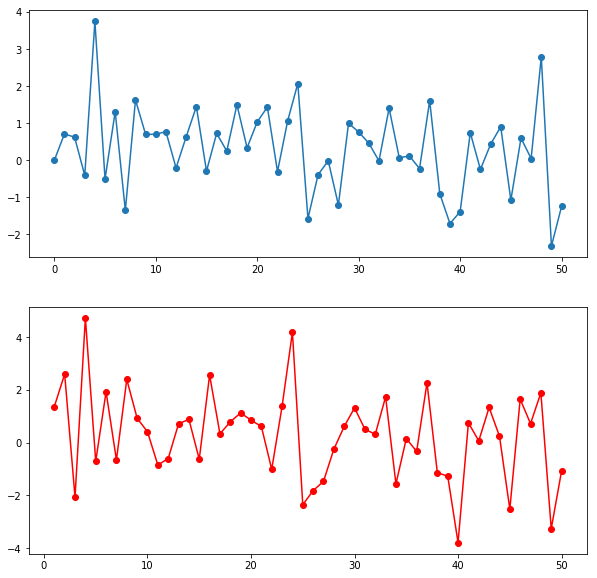

In [2]:
T = 50

xs_sim = np.zeros((T + 1,))
ys_sim = np.zeros((T,))

# Initial state
xs_sim[0] = 0.
for t in range(T):
    xs_sim[t + 1] = np.cos(xs_sim[t]) + stats.norm.rvs()
    
ys_sim = xs_sim[1:] + stats.norm.rvs(0, 1, T)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(xs_sim, 'o-')
axs[1].plot(range(1, T + 1), ys_sim, 'o-r')

Bootstrap particle filter giving an estimate $\widehat{z}_\theta$ of the joint likelihood $p(y_{1:T}\,\big|\,\theta)$.

In [3]:
def log_likelihood_bootstrap_pf(y, N=20, theta=1):
    # Cumulatively build up log-likelihood
    ll = 0.0
    # Initialisation
    samples = stats.norm.rvs(0, 1, N)
    weights = 1 / N * np.ones((N,))
    
    # Determine the number of time steps
    T = len(y)
    # Loop through all time steps
    for t in range(T):
        # Resample
        ancestors = np.random.choice(samples, size=N, 
                                     replace=True, p=weights)
        
        # Propagate
        samples = stats.norm.rvs(0, 1, N) + np.cos(theta * ancestors)
        
        # Weight
        weights = stats.norm.logpdf(y[t], loc=samples, scale=1)
        # Calculate the max of the weights
        max_weights = np.max(weights)
        # Subtract the max
        weights = weights - max_weights
        # Update log-likelihood
        ll += max_weights + np.log(np.sum(np.exp(weights))) - np.log(N)

        # Normalize weights to be probabilities
        weights = np.exp(weights) / np.sum(np.exp(weights))
  
    return ll

In [53]:
log_likelihood_bootstrap_pf(ys_sim, N=50, theta=3)

-98.769029262044185

As a proposal we can use $q(\theta'\,\big|\,\theta[k - 1]) = \mathcal{N}\left(\theta';\,\theta[k - 1], \tau\right)$ with an appropriately chosen $\tau$.

Implement a Metropolis-Hastings sampler with the above.

In [57]:
def particle_metropolis_hastings(y, M=10000, N=20, tau=1):
    theta = np.zeros((M + 1,))
    alphas = np.zeros((M,))
    
    # Initial state
    theta[0] = 0
    # Iterate the chain
    for i in tqdm(range(M)):
        # Sample a new value
        theta_prop = stats.norm.rvs(theta[i], tau, 1)
        # Sample to be compared to the acceptance probability
        u = stats.uniform.rvs()
        
        # Terms in the second part of the acceptance probability -
        # Proposal is symmetric, so terms containing the proposal will
        # cancel each other out
        num = log_likelihood_bootstrap_pf(y, N=N, theta=theta_prop) + \
            stats.norm.logpdf(theta_prop)
        denom = log_likelihood_bootstrap_pf(y, N=N, theta=theta[i]) + \
            stats.norm.logpdf(theta[i])
            
        # Acceptance probability
        alpha = min(1, np.exp(num - denom))
        alphas[i] = alpha
        # Set next state depending on acceptance probability
        if u <= alpha:
            theta[i + 1] = theta_prop
        else:
            theta[i + 1] = theta[i]
            
    return theta, alphas

In [58]:
pars, alphas = particle_metropolis_hastings(ys_sim, M=10000, N=50, tau=0.7)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:02<00:00, 28.42it/s]


In [59]:
np.mean(alphas)

0.43288517028512286

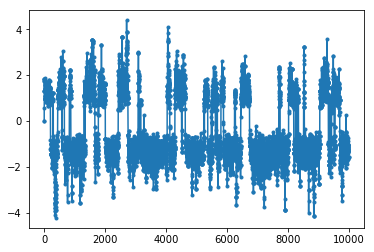

In [60]:
fig, ax = plt.subplots()
ax.plot(pars, '.-')

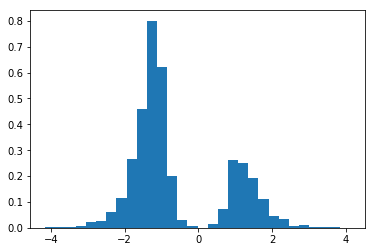

In [92]:
fig, ax = plt.subplots()
ax.hist(pars[3000:], normed=True, bins=30);

## IV.2 Conditional Particle Filter

I will turn the fully adapted particle filter from exercise II.2 into a conditional particle filter by including a reference state trajectory and in each propagation step the refernence state trajectory delivers one of the particles. States and their ancestors will be saved and the algorithm returns a new state trajectory conditional on the old one.

The state-space model under consideration is (normal distribution parametrized with $\sigma$)
$$
\begin{array}{rll}
x_{t + 1} &= \cos(x_t)^2 + v_t, & v_t \sim N(0, 1) \\
y_t &= 2 x_t + e_t, & e_t \sim N(0, 0.1)
\end{array}
$$
which leads to the probabilistic model
$$
\begin{align}
p(x_t\,|\,x_{t - 1}) &= N\left(x_t;\,\cos(x_t)^2,\,1\right) \\
p(y_t\,|\,x_t) &= N\left(y_t;\,2 x_t,\,0.1\right)
\end{align}
$$
This admits the necessary pdfs
$$
\begin{align}
p(y_t\,|\,x_{t - 1}) &= N(y_t;\,2 \cos(x_{t - 1})^2,\,\sqrt{4.01}) \\
p(x_t\,|\,x_{t - 1},\,y_t) &= N\left(x_t;\,\frac{2 y_t + 0.01 \cos(x_{t - 1})^2}{4.01}, \frac{0.1}{\sqrt{4.01}}\right) 
\end{align}
$$

In [101]:
def conditional_FAPF(x_ref, y, N=200):
    # Determine length of data
    T = len(y)
    # Save the paths of all final particles
    xs = np.zeros((N, T + 1))
    # Initialisation
    xs[:, 0] = stats.norm.rvs(0, 1, N)
    # Replace last state with state from reference trajectory
    xs[N - 1, 0] = x_ref[0]
    
    for t in range(T):
        # Calculate resampling weights in case of FAPF
        ws = stats.norm.logpdf(y[t], loc=2*np.power(np.cos(xs[:, t]), 2), 
                               scale=np.sqrt(4.01))
        # Subtract maximum weight
        ws -= np.max(ws)
        # Normalize the resampling weights
        ws = np.exp(ws) / np.sum(np.exp(ws))
            
        # Resample
        ancestors = np.random.choice(range(N), size=N, replace=True, p=ws)
        
        # Propagate
        xs[:, t + 1] = stats.norm.rvs(0, 1, N) * 0.1 / np.sqrt(4.01) + \
            (2 / 4.01) * y[t] + (0.01 / 4.01) * \
            np.power(np.cos(xs[ancestors, t]), 2)
        # Replace last sample with reference trajectory
        ancestors[N - 1] = N - 1
        xs[N - 1, t + 1] = x_ref[t + 1]
        # Update the ancestor lines
        xs[:, 0:t] = xs[ancestors, 0:t]

    # Randomly choose trajectory which will be returned
    # All normalized weights are 1 / N, so that no draw from
    # a categorical distribution is necessary. A uniform draw
    # is satisfactory.
    b = np.random.randint(N)  
    
    return xs[b, :]

Simulate from the model given above.

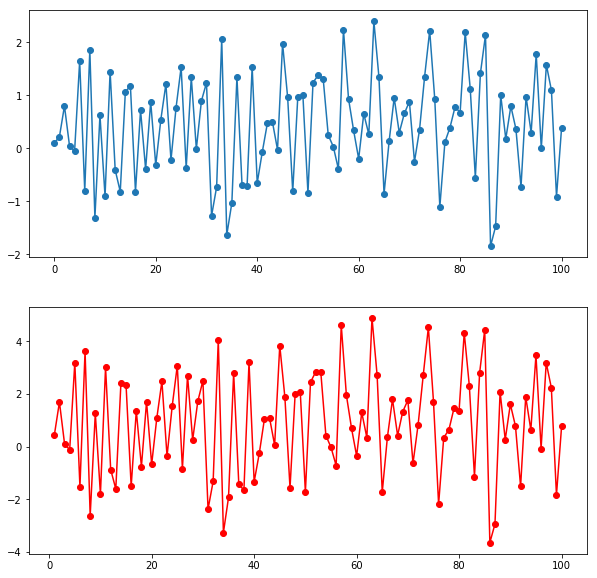

In [56]:
T = 100

# Allocate arrays for results
ys_sim = np.zeros((T,))
xs_sim = np.zeros((T + 1,))
# Initial value for state
xs_sim[0] = 0.1
# Walk through all time steps
for t in range(T):
    xs_sim[t + 1] = np.power(np.cos(xs_sim[t]), 2) + stats.norm.rvs(0, 1, 1)
    ys_sim[t] = 2 * xs_sim[t + 1] + stats.norm.rvs(0, 0.1, 1)
    
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(range(T + 1), xs_sim, 'o-');
axs[1].plot(range(1, T + 1), ys_sim, 'o-r');

This is a Markov kernel which can be used in Gibbs sampling where the parameters and the hidden state are sampled repeatedly consecutively.

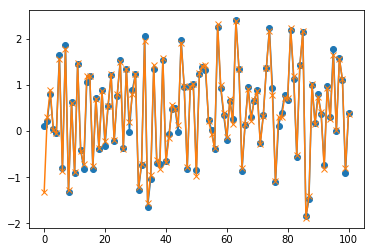

In [151]:
xs = conditional_FAPF(xs_sim, ys_sim, N=1000)

fig, ax = plt.subplots()
ax.plot(xs_sim, 'o-')
ax.plot(xs, 'x-');

## IV.3 Conditional importance sampling

### a) Conditional importance sampling with few particles

Sample from $\pi(x) = \mathcal{N}\left(x\,\big|\,1,\,1\right)$ by using conditional importance sampling with the proposal $q(x) = \mathcal{N}\left(x\,\big|\,0,\,1\right)$.

In [62]:
def cond_imp_sampling_kernel(x, N=2):
    # Sample new proposals
    xs = stats.norm.rvs(0, 1, N)
    # Set the last sample to the reference
    xs[N - 1] = x
    
    # Calculate weights
    ws = stats.norm.logpdf(xs, loc=1, scale=1) - \
        stats.norm.logpdf(xs, loc=0, scale=1)
    ws -= np.max(ws)
    ws = np.exp(ws) / np.sum(np.exp(ws))
    
    return xs[np.random.choice(range(N), 1, p=ws)]

Use that kernel to sample from the target distribution.

In [94]:
def cond_imp_sampling_mcmc(M=1000, N=2):
    # Initialisation
    xs = np.zeros((M + 1,))
    for m in tqdm(range(M)):
        xs[m + 1] = cond_imp_sampling_kernel(xs[m], N=N)
        
    return xs

Run the sampler

In [103]:
xs = cond_imp_sampling_mcmc(M=70000)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:35<00:00, 1956.26it/s]


Plot the result

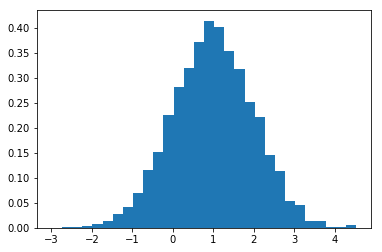

In [104]:
fig, ax = plt.subplots()
ax.hist(xs, normed=True, bins=30);

### b) Lower bound for probability that draw from cond. imp. sampling kernel falls in a set $A$

Theoretical exercise. Solution will be in `exercises_on_paper`.

## IV.4 An SMC sampler for localization

A point $x_0$ is supposed to be localized in the plane $[-12,\,12]^2$. 

There are some measurements $y_{1:M}$ which are corrupted by heavy-tailed noise from an exponential distribution.

We want to find the distribution $p\left(x_0\,\big|\,y_{1:M}\right)$.

### a) Simulate data

$M$ simulated measurements from the model
$$
\begin{align}
    y_t^1 &= x_0^1 + n_m^1 b_m^1 \\
    y_t^2 &= x_0^2 + n_m^2 b_m^2
\end{align}
$$
where
$$
\begin{align}
    m &= 1, 2, \dots, M \\
    x_0 &= \left(x_0^1, x_0^2\right) \\
    n_m^1, n_m^2 &\sim \mathrm{Exp}\left(2\right) \\
    \mathbb{P}\left(b_m^1 = 1\right) &= \mathbb{P}\left(b_m^1 = -1\right) = \frac{1}{2}
\end{align}
$$
and analogously for $b_m^2$.

In [124]:
M = 20
x0 = np.array([2.0, -5.5])
ns = np.reshape(stats.expon.rvs(scale=2, size=2 * M), (2, M))
bs = np.reshape(np.random.choice([-1, 1], size=2 * M, 
                                 replace=True, p=[0.5, 0.5]), 
                (2, M))

ys = np.reshape(np.repeat(x0, M), (2, M)) + ns * bs

### b) Likelihood

We know that
$$
\begin{align}
    p\left(y_m\,\big|\,x_0\right) &= p\left(x_0 + n_m \cdot b_m = y_m\,\big|\,x_0\right) = \\
    &= \sum_{i \in \left\{-1, 1\right\}} p\left(n_m = y_m - i \cdot x_0\,\big|\,x_0\right) = \\
    &= \frac{1}{2} \left(\exp\left(-\frac{y_m + x_0}{2}\right) + \exp\left(-\frac{y_m - x_0}{2}\right)\right)
\end{align}
$$
and therefore
$$
p\left(y_{1:M}\,\big|\,x_0\right)
$$